# RUSTY BARGAIN

## Descripción

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. 

Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios.

A Rusty Bargain le interesa:

* La calidad de la predicción
* La velocidad de la predicción
* El tiempo requerido para el entrenamiento

## Objetivo

Crear un modelo que determine el valor de mercado.

## Consideraciones

Para este proyecto consideraré:

1. Features:

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo


2. Target

- Price — precio (en euros)

## Carga de datos y librerias

In [50]:
# Cargaré todas las librerías que necesito.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from lightgbm.callback import early_stopping, log_evaluation
import math
import time
from sklearn.preprocessing import OrdinalEncoder

In [51]:
# Cargaré los datos del nuevo dataset.
car_data = pd.read_csv('/Users/brisna/github_projects/tripleten/rusty_bargain/car_data.csv')


In [52]:
car_data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42
354365,14/03/2016 17:48,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,14/03/2016 00:00,0,39576,06/04/2016 00:46
354366,05/03/2016 19:56,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,05/03/2016 00:00,0,26135,11/03/2016 18:17
354367,19/03/2016 18:57,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,19/03/2016 00:00,0,87439,07/04/2016 07:15


## Preparación de datos

In [53]:
# Veré la información general de mi dataframe.
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [54]:
# Revisaré si hay datos nulos.
car_data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Después de revisar la información puedo observar que hay algunas variables que requieren atención:
- Cambiaré los NaN de VehicleType, Gearbox, Model, Fueltype y NotRepaired por "Desconocido".

In [55]:
# Cambiaré los NaN de VehicleType, Gearbox, Model, Fueltype y NotRepaired por "Desconocido".
unknown_columns = ["VehicleType", "Gearbox", "Model", "FuelType", "NotRepaired"]
car_data[unknown_columns] = car_data[unknown_columns].fillna("Desconocido")

In [56]:
#Le daré formato a los encabezados para que queden uniformes.
new_col_names = []
for old_name in car_data.columns:
    name_stripped = old_name.strip()
    name_lowered = re.sub(r'(?<!^)(?=[A-Z])', '_', name_stripped).lower()
    name_no_spaces = name_lowered.replace(" ", "_")
    new_col_names.append(name_no_spaces)

car_data.columns = new_col_names

In [57]:
# Revisaré cómo quedaron los encabezados.
car_data.sample(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
44909,13/03/2016 23:38,4300,wagon,2005,auto,150,e_klasse,150000,4,gasoline,mercedes_benz,no,13/03/2016 00:00,0,91074,06/04/2016 21:18
99534,09/03/2016 22:51,5200,bus,2004,auto,140,touran,150000,10,gasoline,volkswagen,Desconocido,09/03/2016 00:00,0,91099,12/03/2016 15:17
241862,11/03/2016 17:57,1000,wagon,1998,manual,125,Desconocido,150000,3,petrol,volkswagen,no,11/03/2016 00:00,0,37170,06/04/2016 13:46
335371,21/03/2016 20:44,1400,sedan,1996,manual,116,other,150000,6,petrol,volvo,no,21/03/2016 00:00,0,1904,30/03/2016 09:18
128788,01/04/2016 18:52,3100,sedan,2000,manual,163,c_klasse,150000,0,petrol,mercedes_benz,Desconocido,01/04/2016 00:00,0,54497,03/04/2016 15:46
251049,22/03/2016 16:38,0,sedan,2001,auto,136,3er,150000,4,gasoline,bmw,no,22/03/2016 00:00,0,59590,22/03/2016 16:38
115949,15/03/2016 19:58,1500,wagon,2000,manual,116,mondeo,150000,9,petrol,ford,no,15/03/2016 00:00,0,40549,15/03/2016 20:40
25320,04/04/2016 07:36,290,small,1998,manual,54,corsa,150000,9,petrol,opel,no,04/04/2016 00:00,0,44135,06/04/2016 10:17
176236,15/03/2016 14:54,600,small,1996,manual,45,corsa,150000,6,petrol,opel,Desconocido,15/03/2016 00:00,0,52538,06/04/2016 06:45
308530,01/04/2016 16:57,1500,Desconocido,2017,Desconocido,58,corsa,150000,10,Desconocido,opel,Desconocido,01/04/2016 00:00,0,83646,03/04/2016 14:17


In [58]:
# Volveré a revisar mi DataFrame. 
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [59]:
# Observaré las estadísticas descriptivas de los datos.
car_data.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Según la descripción de los datos, puedo observar que:
1. Hay 354,107 registros.
2. Se capturaron datos del 5 de marzo al 7 de abril de 2016.
3. El precio promedio es de $4,416.43 siendo 0 el precio más bajo y $20,000 el más alto registrado (revisaré esto más adelante).
4. La desviación estándar es de $4,514.34 lo que indica una alta variabilidad en los precios.
5. El año promedio de registro es 2004. Sin embargo, el año más bajo registrado es 1000 el más alto es 9999 por lo que revisaré también estos datos a detalle.
6. La potencia promedio es de 110.09 siendo 0 la potencia mínima y 20,000 la máxima lo que me indica que podría haber errores en los datos.
7. El kilometraje promedio es de 128,211.81km. El kilometraje más bajo es de 5,000km y el más alto es de 150,000km. La desviación estándar es de 37,906.59, lo que indica que los datos están muy dispersos.
8.  El mes promedio de registro es de 5.71, lo que indica que la mayoría de los vehículos se registraron entre mayo y junio. El mes mínimo registrado es 0 lo cual podría indicar que el mes de registro es desconocido. La desviación estándar es 3.73, lo que indica una distribución normal de los datos.
9. La fecha promedio de creación es el 20 de marzo de 2016 teniendo un periodo de tiempo de creación del 10 de marzo de 2014 al 7 de abril de 2016.
10.  Observo que la columna number_of_pictures contiene solo ceros como valor por lo que podría eliminarla.
11.  La columna postal_code tiene un rango que va del CP 1067 al 99998 lo que podría indicar que los autos pertenecen a diferentes regiones del país.

## Análisis exploratorio de datos

In [60]:
car_data = car_data[car_data['price'] > 0]

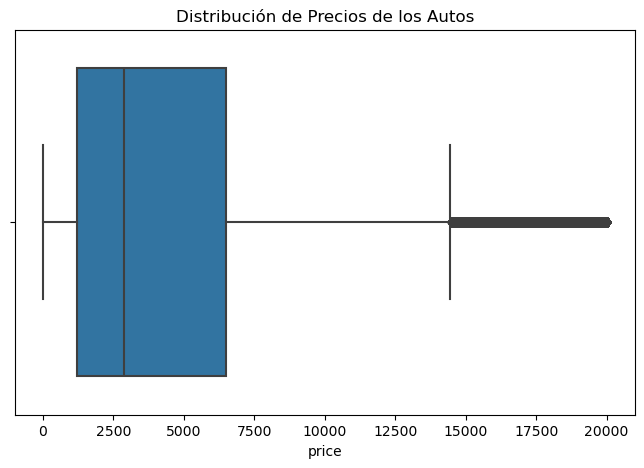

In [61]:
# Revisaré los datos atípicos relacionados con el precio sin considerar el precio cero (0).
plt.figure(figsize=(8, 5))
sns.boxplot(x=car_data['price'])
plt.title('Distribución de Precios de los Autos')
plt.show()

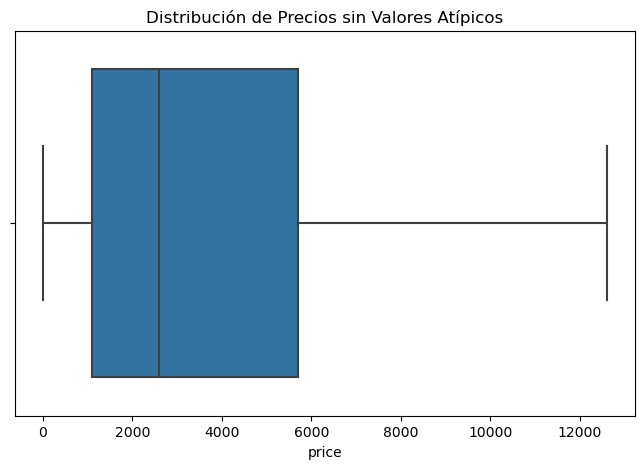

In [62]:
# Calcularé el Q1 (percentil 25) y Q3 (percentil 75)
Q1 = car_data['price'].quantile(0.25)
Q3 = car_data['price'].quantile(0.75)

# Calcularé el IQR
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtraré los datos límites
car_data_filtered = car_data[(car_data['price'] >= lower_bound) & (car_data['price'] <= upper_bound)]

# Haré un boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=car_data_filtered['price'], showfliers=False)
plt.title('Distribución de Precios sin Valores Atípicos')
plt.show()

In [63]:
# Quitaré las variables de poco valor previo a la realización de mi modelo.
data_model = car_data_filtered.drop(['postal_code', 'last_seen', 'date_created', 'date_crawled', 'number_of_pictures', 'registration_month'], axis=1)
data_model.describe()

,price,registration_year,power,mileage
count,324690.000000,324690.000000,324690.000000,324690.000000
mean,3836.578678,2003.756697,107.040411,130368.859528
std,3467.616852,77.462017,189.744936,35895.895493
min,1.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,68.000000,125000.000000
50%,2600.000000,2003.000000,102.000000,150000.000000
75%,5700.000000,2007.000000,140.000000,150000.000000
max,14450.000000,9999.000000,20000.000000,150000.000000


In [64]:
# Filtraré solo carros entre 1950 y 2025
data_model = data_model[(data_model['registration_year'] >= 1950) & (data_model['registration_year'] <= 2025)]

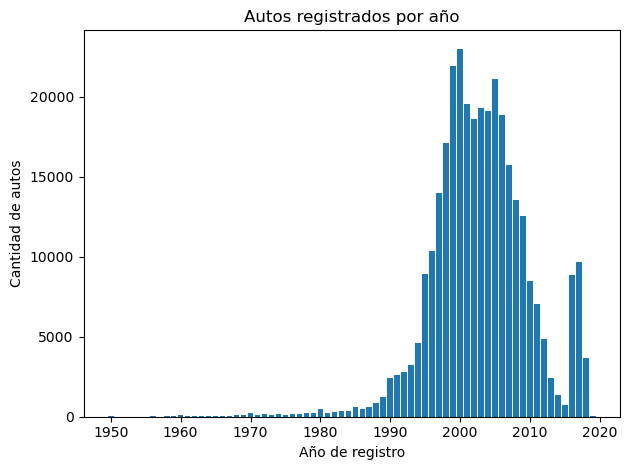

In [65]:
# Veré la cantidad de autos que hay por año de registro.
registration_year_count = data_model['registration_year'].value_counts().sort_index()
plt.figure()
plt.bar(registration_year_count.index, registration_year_count.values)
plt.xlabel('Año de registro')
plt.ylabel('Cantidad de autos')
plt.title('Autos registrados por año')
plt.tight_layout()
plt.show()

/var/folders/r2/pwb3zvz948v6cw4px750f0dc0000gn/T/ipykernel_35933/2601064440.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_model = data_model[car_data['power'] > 0]


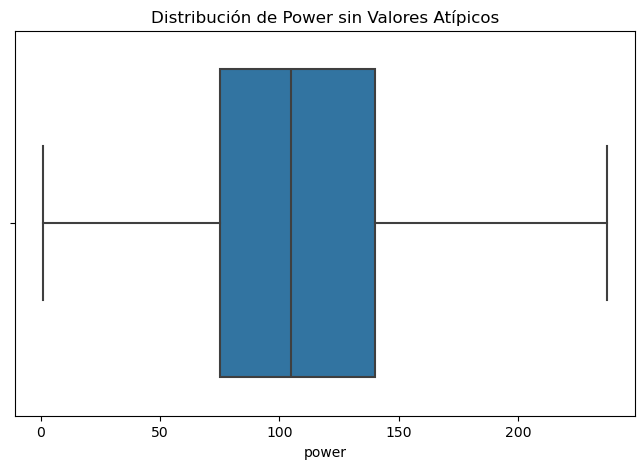

In [66]:
# Revisaré los datos atípicos relacionados con el power sin considerar el cero (0).
data_model = data_model[car_data['power'] > 0]

# Calcularé el Q1 (percentil 25) y Q3 (percentil 75)
Q1 = data_model['power'].quantile(0.25)
Q3 = data_model['power'].quantile(0.75)

# Calcularé el IQR
IQR = Q3 - Q1

lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Filtraré los datos límites
data_model_filtered = data_model[(data_model['power'] >= lower) & (data_model['power'] <= upper)].copy()

# Haré un boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=data_model_filtered['power'], showfliers=False)
plt.title('Distribución de Power sin Valores Atípicos')
plt.show() 

In [67]:
data_model_filtered.reset_index(inplace=True)
data_model_filtered

,index,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,Desconocido
1,3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
3,5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
283187,354361,5250,Desconocido,2016,auto,150,159,150000,Desconocido,alfa_romeo,no
283188,354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
283189,354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
283190,354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [68]:
# Verificaré si tengo datos duplicados.
data_model_filtered[data_model_filtered.duplicated()]

,index,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired


In [69]:
# Obtendré las variables categóricas para codificarlas.
categorical_chars = list(data_model_filtered.dtypes[data_model_filtered.dtypes == 'object'].index)
categorical_chars

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [70]:
for char in categorical_chars:
    print(data_model_filtered[char].value_counts())
    print()

vehicle_type
sedan          75625
small          69274
wagon          54765
bus            24503
Desconocido    20586
convertible    16271
coupe          11928
suv             7874
other           2366
Name: count, dtype: int64

gearbox
manual         229216
auto            48085
Desconocido      5891
Name: count, dtype: int64

model
golf           24440
other          18617
3er            16488
Desconocido    11496
polo           11057
               ...  
q3                 3
rangerover         2
serie_3            2
cayenne            1
gl                 1
Name: count, Length: 249, dtype: int64

fuel_type
petrol         180018
gasoline        79152
Desconocido     18999
lpg              4213
cng               495
hybrid            156
other              92
electric           67
Name: count, dtype: int64

brand
volkswagen        62689
opel              33295
bmw               28457
mercedes_benz     23877
audi              22181
ford              20596
renault           14409
peugeo

In [71]:
# Haré una codificación ordinal para model y brand.
data_model_filtered[['model', 'brand']] = OrdinalEncoder().fit_transform(data_model_filtered[['model', 'brand']])
data_model_filtered

,index,price,vehicle_type,registration_year,gearbox,power,model,mileage,fuel_type,brand,not_repaired
0,2,9800,suv,2004,auto,163,118.0,125000,gasoline,14.0,Desconocido
1,3,1500,small,2001,manual,75,117.0,150000,petrol,38.0,no
2,4,3600,small,2008,manual,69,102.0,90000,gasoline,31.0,no
3,5,650,sedan,1995,manual,102,11.0,150000,petrol,2.0,yes
4,6,2200,convertible,2004,manual,109,8.0,150000,petrol,25.0,no
...,...,...,...,...,...,...,...,...,...,...,...
283187,354361,5250,Desconocido,2016,auto,150,4.0,150000,Desconocido,0.0,no
283188,354362,3200,sedan,2004,manual,225,141.0,150000,petrol,30.0,yes
283189,354366,1199,convertible,2000,auto,101,107.0,125000,petrol,32.0,no
283190,354367,9200,bus,1996,manual,102,223.0,150000,gasoline,38.0,no


In [72]:
data_ohe = pd.get_dummies(data_model_filtered, drop_first=True)
data_ohe

,index,price,registration_year,power,model,mileage,brand,vehicle_type_bus,vehicle_type_convertible,vehicle_type_coupe,...,gearbox_manual,fuel_type_cng,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_lpg,fuel_type_other,fuel_type_petrol,not_repaired_no,not_repaired_yes
0,2,9800,2004,163,118.0,125000,14.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,3,1500,2001,75,117.0,150000,38.0,False,False,False,...,True,False,False,False,False,False,False,True,True,False
2,4,3600,2008,69,102.0,90000,31.0,False,False,False,...,True,False,False,True,False,False,False,False,True,False
3,5,650,1995,102,11.0,150000,2.0,False,False,False,...,True,False,False,False,False,False,False,True,False,True
4,6,2200,2004,109,8.0,150000,25.0,False,True,False,...,True,False,False,False,False,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283187,354361,5250,2016,150,4.0,150000,0.0,False,False,False,...,False,False,False,False,False,False,False,False,True,False
283188,354362,3200,2004,225,141.0,150000,30.0,False,False,False,...,True,False,False,False,False,False,False,True,False,True
283189,354366,1199,2000,101,107.0,125000,32.0,False,True,False,...,False,False,False,False,False,False,False,True,True,False
283190,354367,9200,1996,102,223.0,150000,38.0,True,False,False,...,True,False,False,True,False,False,False,False,True,False


HALLAZGOS Y ACCIONES:

* El dataset tenía varias columnas con valores faltantes y outliers que podrían sesgar los modelos. Después de imputar valores nulos y filtrar outliers en RegistrationYear, Power y Mileage, los datos quedaron más homogéneos.

* Transformé las variables de fecha para extraer características (mes, año, etc.), lo que puede enriquecer los modelos basados en “edad” del anuncio o del vehículo.

* No encontré valores duplicados sospechosos en el dataset, y la columna NumberOfPictures estaba en 0, por lo que decidí descartarla.

## Entrenamiento de modelos

In [73]:
# Definiré mis metricas para el modelo.
train_valid, test = train_test_split(data_ohe, test_size=0.2, random_state=12345)
train, valid = train_test_split(train_valid, test_size=0.25,random_state=12345)

In [74]:
# Agregaré el RMSE para evaluar la precisión de mi modelo.
def rmse(prediction, real_value):
    return math.sqrt(mean_squared_error(prediction,real_value))

In [75]:
# Preparo mis datos para entrenar mi modelo.
train_chars = train.drop('price', axis=1)
valid_chars = valid.drop('price', axis=1)
test_chars  = test.drop('price', axis=1)

train_target = train['price']
valid_target = valid['price']
test_target  = test['price']

print("train_chars:", train_chars.shape, "train_target:", train_target.shape)
print("valid_chars:", valid_chars.shape, "valid_target:", valid_target.shape)

# Entrenamiento y prueba combinando train y valid
X_train_lr = pd.concat([train_chars, valid_chars])
y_train = pd.concat([train_target, valid_target])

X_test_lr = test_chars
y_test = test_target


train_chars: (169914, 25) train_target: (169914,)
valid_chars: (56639, 25) valid_target: (56639,)


In [76]:
# Haré un modelo de Regresión Lineal
model_lr = LinearRegression()
t0 = time.time()
model_lr.fit(X_train_lr, y_train)
train_preds_lr = model_lr.predict(X_train_lr)
test_preds_lr = model_lr.predict(X_test_lr)
results_lr = {'train_rmse': rmse(y_train, train_preds_lr), 'test_rmse': rmse(y_test, test_preds_lr), 'train_time': time.time() - t0}
print(f"Linear Regression -> Train RMSE: {results_lr['train_rmse']:.2f}, Test RMSE: {results_lr['test_rmse']:.2f}, Time: {results_lr['train_time']:.1f}s")

Linear Regression -> Train RMSE: 2258.90, Test RMSE: 2246.50, Time: 0.2s


In [77]:
# Haré un modelo de Random Forest
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10], 'min_samples_split': [2, 5]}
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
gs_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

t0 = time.time()
gs_rf.fit(X_train_lr, y_train)
model_rf = gs_rf.best_estimator_
train_preds_rf = model_rf.predict(X_train_lr)
test_preds_rf = model_rf.predict(X_test_lr)
results_rf = {'best_params': gs_rf.best_params_, 'train_rmse': rmse(y_train, train_preds_rf), 'test_rmse': rmse(y_test, test_preds_rf), 'train_time': time.time() - t0}
print(f"Random Forest -> Params: {results_rf['best_params']}, Train RMSE: {results_rf['train_rmse']:.2f}, Test RMSE: {results_rf['test_rmse']:.2f}, Time: {results_rf['train_time']:.1f}s")

Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Random Forest -> Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}, Train RMSE: 658.40, Test RMSE: 1337.54, Time: 353.0s


In [78]:
# Intentaré hacer un modelo de LightGBM.
model_lgbm = LGBMRegressor(
    n_estimators=1000,
    metric='rmse',
    verbose=-1
)
model_lgbm.fit(
    train_chars, train_target,
    eval_set=[(valid_chars, valid_target)],
    eval_metric='rmse',
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)
train_preds_lgbm = model_lgbm.predict(X_train_lr)
test_preds_lgbm = model_lgbm.predict(X_test_lr)
results_lgbm = {
    'train_rmse': rmse(y_train, train_preds_lgbm),
    'test_rmse': rmse(y_test, test_preds_lgbm),
    'train_time': time.time() - t0
}
print(f"LightGBM -> Train RMSE: {results_lgbm['train_rmse']:.2f}, Test RMSE: {results_lgbm['test_rmse']:.2f}, Time: {results_lgbm['train_time']:.1f}s")

Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 1431.76
[100]	valid_0's rmse: 1372.56
[150]	valid_0's rmse: 1350.03
[200]	valid_0's rmse: 1336.27
[250]	valid_0's rmse: 1325.22
[300]	valid_0's rmse: 1318.71
[350]	valid_0's rmse: 1313.77
[400]	valid_0's rmse: 1307.92
[450]	valid_0's rmse: 1304.47
[500]	valid_0's rmse: 1300.28
[550]	valid_0's rmse: 1297.1
[600]	valid_0's rmse: 1295.26
[650]	valid_0's rmse: 1292.75
[700]	valid_0's rmse: 1291.02
[750]	valid_0's rmse: 1289.5
[800]	valid_0's rmse: 1287.38
[850]	valid_0's rmse: 1286.13
[900]	valid_0's rmse: 1285.11
[950]	valid_0's rmse: 1284.1
[1000]	valid_0's rmse: 1283.46
Did not meet early stopping. Best iteration is:
[996]	valid_0's rmse: 1283.45
LightGBM -> Train RMSE: 1176.77, Test RMSE: 1305.89, Time: 358.0s


Conclusiones después de entrenar los modelos:

* La Regresión Lineal es muy rápida, pero su calidad (RMSE) es la más baja.

* El modelo de Random Forest mejora mucho el RMSE, pero el tiempo de entrenamiento es moderado.

* LightGBM logra el mejor equilibrio entre calidad y velocidad (RMSE más bajo y entrenamiento más rápido que XGBoost o RF con muchos árboles).

## Conclusiones finales

Recomiendo usar LightGBM en producción ya que ofrece predicciones rápidas y de buena calidad aunque si el objetivo es maximizar la precisión y el tiempo de entrenamiento no es crítico, es buena idea también usar Random Forest con los parámetros óptimos encontrados.

La Regresión Lineal será una buena opción solo como referencia rápida cada vez que se modifiquen características o se añadan nuevas variables.